![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Tutorial

This notebook is the first of two that demonstrate pixels-to-actions training using the experimental Madrona rendering backend.

### Usage

This is a simplified version of the main cartpole balance [tutorial](https://github.com/google-deepmind/mujoco_playground/blob/main/learning/notebooks/training_vision_1.ipynb), adjusted to run on a hosted instance with a T4 GPU.

### Build and Install Madrona MJX (5 min on hosted instance)

In [ ]:
# %%bash
# cat >setup.bash <<EOF

# # Ensure Jax matches the CUDA that will be used to build Madrona MJX
# !pip uninstall -y jax
# !pip install jax["cuda12_local"]==0.4.35

# ! sudo apt install libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

# # Prevent Python from trying to import the source packages.
# mkdir modules
# cd modules

# # -- 7) Install madrona-mjx
# echo "Cloning madrona-mjx..."
# git clone https://github.com/shacklettbp/madrona_mjx.git

# cd madrona_mjx
# git submodule update --init --recursive

# mkdir build
# cd build
# cmake -DLOAD_VULKAN=OFF ..
# make -j 8

# cd ..
# pip install -e .
# EOF

In [1]:
import subprocess
# Run the setup.bash script
subprocess.run(["bash", "setup.bash"], check=True)

bash: setup.bash: No such file or directory


CalledProcessError: Command '['bash', 'setup.bash']' returned non-zero exit status 127.

Now, after installing Madrona MJX, please **restart your colab** instance! (`Runtime -> Restart session`)

### Install Playground and Pre-requisites

In [ ]:
# !pip install mujoco
# !pip install mujoco_mjx
# !pip install brax
# !pip install playground
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy

In [1]:
# @title Configuration for both local and for Colab instances.

# On your second reading, load the compiled rendering backend to save time!
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Check if MuJoCo installation was successful
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    print('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Thu Apr 17 21:10:38 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P5              22W / 170W |   1151MiB / 12288MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [3]:
import mujoco

In [4]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
import time

from brax.training.agents.ppo import networks_vision as ppo_networks_vision
from brax.training.agents.ppo import train as ppo
from IPython.display import clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import numpy as np

from mujoco_playground import wrapper

np.set_printoptions(precision=3, suppress=True, linewidth=100)

Now, let's load Mujoco Playground's JAX Cartpole re-implementation. While we're at it, we'll configure it for the upcoming training. Please note that calling `dm_control_suite.load` builds the rendering backend, taking around **3 minutes** on a T4 instance.

In [5]:
from mujoco_playground import dm_control_suite


num_envs = 512
ctrl_dt = 0.04
episode_length = int(3 / ctrl_dt)

config_overrides = {
    "vision": True,
    "vision_config.render_batch_size": num_envs,
    "action_repeat": 1,
    "ctrl_dt": ctrl_dt,
    "episode_length": episode_length,
}

env_name = "CartpoleBalance"
env = dm_control_suite.load(
    env_name, config_overrides=config_overrides
)

env = wrapper.wrap_for_brax_training(
    env,
    vision=True,
    num_vision_envs=num_envs,
    action_repeat=1,
    episode_length=episode_length,
)

Using raytracer
Compiling /home/dimitris/Documents/Github/madrona_mjx/external/madrona/src/mw/device/bvh.cpp
Compiling /home/dimitris/Documents/Github/madrona_mjx/external/madrona/src/mw/device/memory.cpp
Compiling /home/dimitris/Documents/Github/madrona_mjx/external/madrona/src/mw/device/host_print.cpp
Compiling /home/dimitris/Documents/Github/madrona_mjx/external/madrona/src/mw/device/bvh_raycast.cpp
Compiling GPU engine code:
Initialization finished


In [6]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

## Balancing a Cartpole

Now, let's train a pixels-to-torque policy to balance a cartpole. In [our implementation]((https://github.com/google-deepmind/mujoco_playground/blob/main/mujoco_playground/_src/dm_control_suite/cartpole.py)), we control the observation dimensionality while encouraging the agent to understand dynamics by setting the observations as grayscale images stacked across sequential timesteps.

#### Visualize the environment

In [7]:
def unvmap(x):
  return jax.tree.map(lambda y: y[0], x)


state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
rollout = [unvmap(state)]

f = 0.2
for i in range(episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            unvmap(state).data.time * 2 * jp.pi * f
            + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.tile(jp.array(action), (num_envs, 1))
  state = jit_step(state, action)
  rollout.append(unvmap(state))

frames = env.render(rollout, camera="fixed", width=256, height=256)
k = next(iter(rollout[0].obs.items()), None)[0]  # ex: pixels/view_0
obs = [r.obs[k][..., 0] for r in rollout]  # visualise first channel

media.show_videos([frames, obs], fps=1.0 / env.dt, height=256)

100%|██████████| 76/76 [00:00<00:00, 1320.37it/s]


#### Train
Training the policy takes 4 minutes on a hosted T4 instance.

In [8]:
from mujoco_playground.config import dm_control_suite_params

# Load vision-specific PPO configuration tuned for CartpoleBalance
ppo_params = dm_control_suite_params.brax_vision_ppo_config(env_name)
ppo_params.episode_length = episode_length
ppo_params.network_factory = ppo_networks_vision.make_ppo_networks_vision
ppo_params['batch_size'] = 128
ppo_params['num_envs'] = ppo_params['num_eval_envs'] = num_envs

In [9]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())


train_fn = functools.partial(
    ppo.train, **dict(ppo_params), progress_fn=progress
)

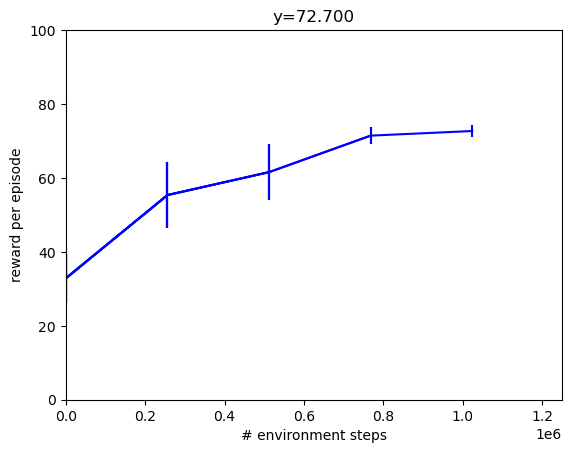

time to jit: 0:00:22.602327
time to train: 0:02:33.530677


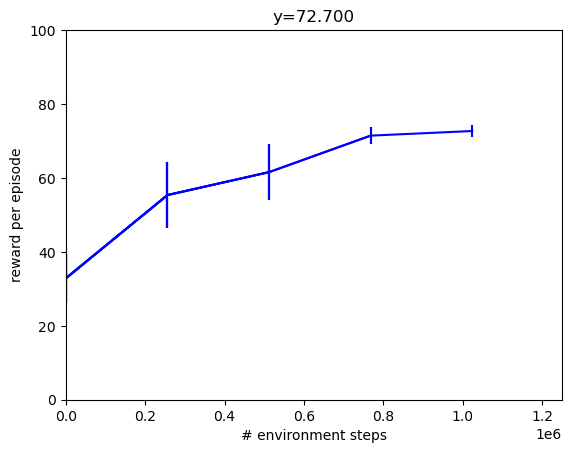

In [10]:
make_inference_fn, params, metrics = train_fn(environment=env)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

#### Visualize the Policy

In [11]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

100%|██████████| 76/76 [00:00<00:00, 401.66it/s]


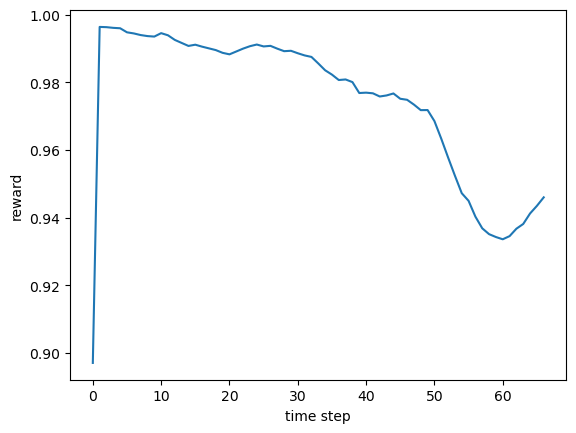

In [12]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  key_rng = jax.random.split(rng, num_envs)
  state = jit_reset(key_rng)
  rollout.append(unvmap(state))
  for i in range(episode_length):
    act_rng, rng = jax.random.split(rng)
    act_rng = jax.random.split(act_rng, num_envs)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(unvmap(state))

render_every = 1
frames = env.render(rollout[::render_every], camera="fixed")
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

plt.plot(np.convolve(rewards, np.ones(10) / 10, mode="valid"))
plt.xlabel("time step")
plt.ylabel("reward")
plt.show()

🙌 Stay tuned for more hosted instances with Madrona-MJX rendering support!